In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np
import io

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

In [2]:
from utils import *
from data import *
from models import *
from train import *

In [3]:
%run data.py
%run utils.py
%run models.py
%run train.py

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Import

In [5]:
data_1lead = import_afc_data()

data_1lead = [x for x in data_1lead if x[1] != '~']

labelmap = {x:i for i,x in enumerate(list(set([x[1] for x in data_1lead])))}

dataset_1lead = WindowDataset(data_1lead, labelmap, device=device)

100%|██████████| 8528/8528 [00:01<00:00, 7303.54it/s]
8249it [00:02, 2774.70it/s]


In [6]:
data_12lead = import_balanced_12lead_data()

dataset_12lead = WindowDataset(data_12lead, labelmap, device=device, trim_samples=1000)

3318it [00:03, 948.25it/s]


In [83]:
pd.Series([x[1] for x in data_1lead]).value_counts()

N    5076
O    2415
A     758
Name: count, dtype: int64

In [84]:
pd.Series([x[1] for x in data_12lead]).value_counts()

O    1106
A    1106
N    1106
Name: count, dtype: int64

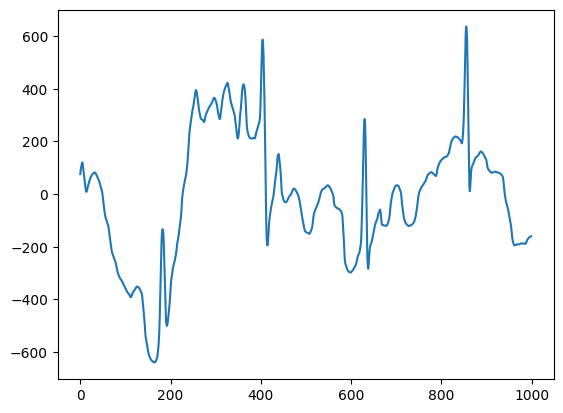

In [85]:
def plotwave(x, n=1000):
    plt.plot(x[:n])

plotwave(data_1lead[19][0])

In [86]:
value_counts = dataset_1lead.get_value_counts(count=3)
weights = [sum(value_counts)/x for x in value_counts]
# weights[labelmap['~']] = weights[labelmap['N']]

In [14]:
value_counts

[5076, 2415, 758]

# Training

## Single-Lead Model

In [ ]:
# Train k-fold crossvalidated model on 1 lead data

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.lr = 0.002
trainparams.n_epochs = 200

# history, confusion_list = train_kfold_model(dataset_1lead, trainparams, test=True)

# plot_tt_graph(history, idx=0)
# display_results(history,trainparams=trainparams)

In [ ]:
def plt_c(cm):
    labelmap2 = {x:y for y,x in labelmap.items()}

    # Converting the confusion matrix to fraction
    cm_fraction = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    print(cm_fraction)

    # Creating a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_fraction, annot=True, fmt=".2f", cmap='Blues', xticklabels=[labelmap2[i] for i in range(4)], yticklabels=[labelmap2[i] for i in range(4)])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix (as fraction)')
    plt.show()

In [88]:
## Build model on entire 1lead dataset and save to buffer

buffer = io.BytesIO()

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.n_epochs = 200

model, history = train_entire_model(dataset_1lead, trainparams)

torch.save(model.state_dict(), buffer)

Epoch:10/200 AVG Training Loss:3.30089 AVG Test Loss:3.29815 AVG Training F1 28.11 % AVG Test F1 15.10 %
Epoch:20/200 AVG Training Loss:3.29964 AVG Test Loss:3.29802 AVG Training F1 27.42 % AVG Test F1 15.10 %
Epoch:30/200 AVG Training Loss:3.29957 AVG Test Loss:3.29799 AVG Training F1 26.72 % AVG Test F1 15.10 %
Epoch:40/200 AVG Training Loss:3.29933 AVG Test Loss:3.29799 AVG Training F1 25.78 % AVG Test F1 15.10 %
Epoch:50/200 AVG Training Loss:3.29901 AVG Test Loss:3.29798 AVG Training F1 26.01 % AVG Test F1 15.10 %
Epoch:60/200 AVG Training Loss:3.29905 AVG Test Loss:3.29799 AVG Training F1 26.59 % AVG Test F1 25.40 %
Epoch:70/200 AVG Training Loss:3.29894 AVG Test Loss:3.29799 AVG Training F1 27.35 % AVG Test F1 15.10 %
Epoch:80/200 AVG Training Loss:3.29887 AVG Test Loss:3.29799 AVG Training F1 27.38 % AVG Test F1 15.10 %
Epoch:90/200 AVG Training Loss:3.29889 AVG Test Loss:3.29799 AVG Training F1 26.53 % AVG Test F1 15.10 %
Epoch:100/200 AVG Training Loss:3.29882 AVG Test Loss:3

## Transfer

Fold 1
Epoch:10/100 AVG Training Loss:1.09662 AVG Test Loss:1.09763 AVG Training F1 37.58 % AVG Test F1 16.66 %
Epoch:20/100 AVG Training Loss:1.08836 AVG Test Loss:1.09499 AVG Training F1 37.40 % AVG Test F1 34.61 %
Epoch:30/100 AVG Training Loss:1.07717 AVG Test Loss:1.06581 AVG Training F1 39.66 % AVG Test F1 46.12 %
Epoch:40/100 AVG Training Loss:0.87527 AVG Test Loss:0.91326 AVG Training F1 61.38 % AVG Test F1 55.88 %
Epoch:50/100 AVG Training Loss:0.64885 AVG Test Loss:0.79883 AVG Training F1 71.05 % AVG Test F1 61.99 %
Epoch:60/100 AVG Training Loss:0.46170 AVG Test Loss:0.74783 AVG Training F1 81.59 % AVG Test F1 66.12 %
Epoch:70/100 AVG Training Loss:0.36525 AVG Test Loss:0.73278 AVG Training F1 86.43 % AVG Test F1 66.48 %
Epoch:80/100 AVG Training Loss:0.27468 AVG Test Loss:0.78433 AVG Training F1 91.09 % AVG Test F1 67.22 %
Epoch:90/100 AVG Training Loss:0.22509 AVG Test Loss:0.77720 AVG Training F1 90.40 % AVG Test F1 68.29 %
Early stopping triggered after epoch 91
Fold 2
E

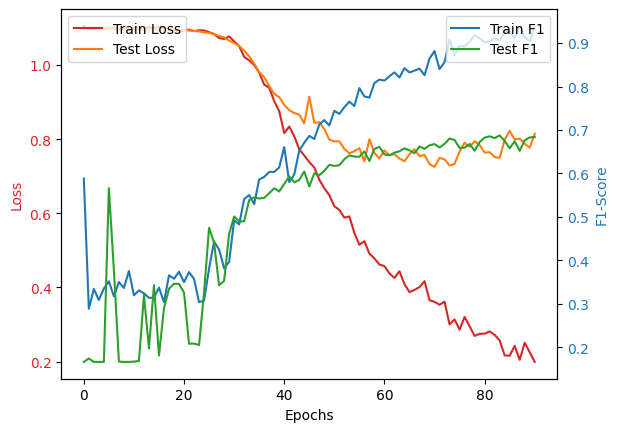

Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.29052293946345653, average F1 score 90.40983460531406
Test: Average loss 0.8323720385630926, average F1 score 70.06480071220457


In [16]:
## Control training - no transfer
## k-fold with leave-(k-1)-out

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=20

history = train_kfold_transfer_model(dataset_12lead, trainparams, TransferFCModel, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

Fold 1
Epoch:10/100 AVG Training Loss:0.66611 AVG Test Loss:0.55461 AVG Training F1 70.29 % AVG Test F1 78.69 %
Epoch:20/100 AVG Training Loss:0.51607 AVG Test Loss:0.46363 AVG Training F1 78.43 % AVG Test F1 81.88 %
Epoch:30/100 AVG Training Loss:0.47651 AVG Test Loss:0.44130 AVG Training F1 79.52 % AVG Test F1 79.98 %
Epoch:40/100 AVG Training Loss:0.44120 AVG Test Loss:0.45416 AVG Training F1 82.52 % AVG Test F1 81.34 %
Epoch:50/100 AVG Training Loss:0.41414 AVG Test Loss:0.43708 AVG Training F1 82.80 % AVG Test F1 80.09 %
Epoch:60/100 AVG Training Loss:0.38165 AVG Test Loss:0.43350 AVG Training F1 83.65 % AVG Test F1 81.77 %
Early stopping triggered after epoch 63
Fold 2
Epoch:10/100 AVG Training Loss:0.77571 AVG Test Loss:0.79352 AVG Training F1 66.45 % AVG Test F1 60.94 %
Epoch:20/100 AVG Training Loss:0.53637 AVG Test Loss:0.48972 AVG Training F1 77.50 % AVG Test F1 77.54 %
Epoch:30/100 AVG Training Loss:0.48176 AVG Test Loss:0.50986 AVG Training F1 80.34 % AVG Test F1 76.45 %
E

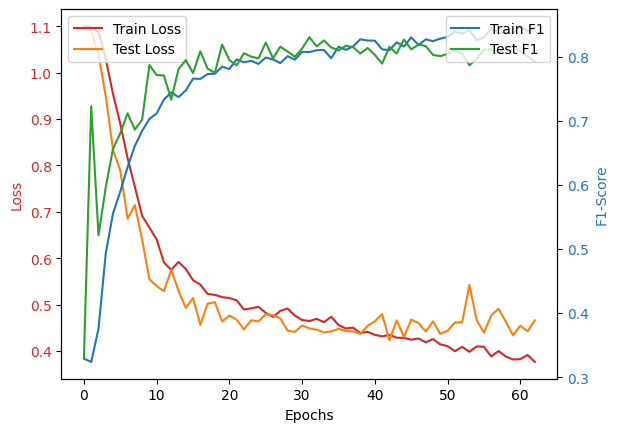

Overall results of 10 fold cross-validation with leave-1-out
Train: Average loss 0.345813484924535, average F1 score 86.49039623016021
Test: Average loss 0.44212636947631834, average F1 score 83.6118393767051


In [17]:
## Control training - no transfer
## k-fold with leave-1-out

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=1
trainparams.early_stopping=20

history = train_kfold_transfer_model(dataset_12lead, trainparams, TransferFCModel, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

Fold 1
Epoch:10/100 AVG Training Loss:0.58780 AVG Test Loss:0.49662 AVG Training F1 79.01 % AVG Test F1 80.14 %
Epoch:20/100 AVG Training Loss:0.48213 AVG Test Loss:0.45237 AVG Training F1 85.17 % AVG Test F1 81.63 %
Early stopping triggered after epoch 23
Fold 2
Epoch:10/100 AVG Training Loss:0.56883 AVG Test Loss:0.52397 AVG Training F1 81.91 % AVG Test F1 76.19 %
Epoch:20/100 AVG Training Loss:0.44597 AVG Test Loss:0.46861 AVG Training F1 88.62 % AVG Test F1 80.24 %
Early stopping triggered after epoch 25
Fold 3
Epoch:10/100 AVG Training Loss:0.56933 AVG Test Loss:0.48955 AVG Training F1 77.80 % AVG Test F1 79.75 %
Epoch:20/100 AVG Training Loss:0.45514 AVG Test Loss:0.45208 AVG Training F1 87.29 % AVG Test F1 81.38 %
Early stopping triggered after epoch 26
Fold 4
Epoch:10/100 AVG Training Loss:0.53632 AVG Test Loss:0.47826 AVG Training F1 86.14 % AVG Test F1 79.40 %
Epoch:20/100 AVG Training Loss:0.41013 AVG Test Loss:0.46532 AVG Training F1 88.31 % AVG Test F1 81.07 %
Early stoppi

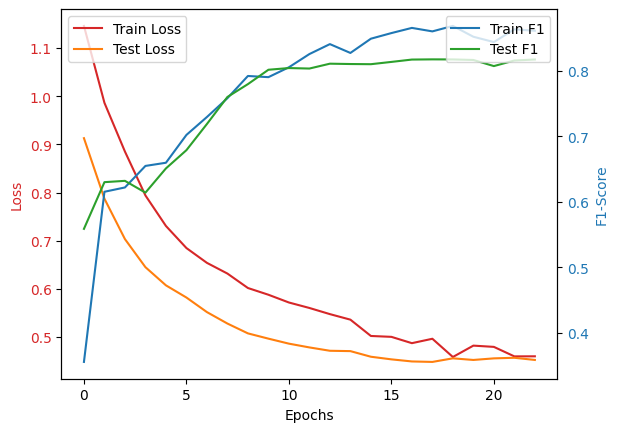

Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.42265739540259045, average F1 score 90.01184550614674
Test: Average loss 0.4614801347255707, average F1 score 81.71594483829831


In [21]:
## Train 10-fold crossvalidated model transferred, 1 -> 12 lead data
## No inter-channel connections, pure vote model

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=5

history = train_kfold_transfer_model(dataset_12lead, trainparams, TransferFCModel, buffer=buffer, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

Fold 1
Epoch:10/100 AVG Training Loss:1.22659 AVG Test Loss:0.60325 AVG Training F1 73.13 % AVG Test F1 71.51 %
Epoch:20/100 AVG Training Loss:1.12856 AVG Test Loss:0.52754 AVG Training F1 83.39 % AVG Test F1 77.09 %
Epoch:30/100 AVG Training Loss:1.09439 AVG Test Loss:0.50857 AVG Training F1 87.08 % AVG Test F1 77.53 %
Epoch:40/100 AVG Training Loss:1.07791 AVG Test Loss:0.49373 AVG Training F1 88.51 % AVG Test F1 77.05 %
Epoch:50/100 AVG Training Loss:1.04829 AVG Test Loss:0.49907 AVG Training F1 91.51 % AVG Test F1 77.53 %
Early stopping triggered after epoch 53
Fold 2
Epoch:10/100 AVG Training Loss:1.12319 AVG Test Loss:0.59176 AVG Training F1 79.05 % AVG Test F1 73.73 %
Epoch:20/100 AVG Training Loss:1.05455 AVG Test Loss:0.51108 AVG Training F1 85.48 % AVG Test F1 78.02 %
Epoch:30/100 AVG Training Loss:1.04761 AVG Test Loss:0.49898 AVG Training F1 86.36 % AVG Test F1 78.36 %
Epoch:40/100 AVG Training Loss:1.05496 AVG Test Loss:0.49535 AVG Training F1 93.29 % AVG Test F1 77.96 %
E

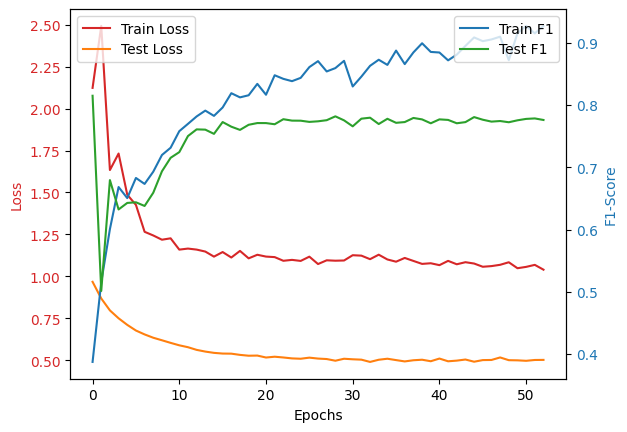

Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 1.075858889023463, average F1 score 93.27976006411177
Test: Average loss 0.5349671237791578, average F1 score 79.43867205891448


In [16]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data
## Transfer adds new fc layer as well as allowing intermediate connections between LSTM1 and LSTM2

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=20

history = train_kfold_transfer_model(dataset_12lead, trainparams, TransferAdaptersLSTMModel, buffer=buffer, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

Fold 1
Epoch:10/200 AVG Training Loss:0.83896 AVG Test Loss:0.69223 AVG Training F1 71.59 % AVG Test F1 64.29 %
Epoch:20/200 AVG Training Loss:0.70427 AVG Test Loss:0.60764 AVG Training F1 77.62 % AVG Test F1 68.54 %
Epoch:30/200 AVG Training Loss:0.58762 AVG Test Loss:0.57952 AVG Training F1 82.17 % AVG Test F1 72.65 %
Epoch:40/200 AVG Training Loss:0.54422 AVG Test Loss:0.57408 AVG Training F1 86.02 % AVG Test F1 75.25 %
Epoch:50/200 AVG Training Loss:0.51477 AVG Test Loss:0.59264 AVG Training F1 88.20 % AVG Test F1 75.30 %
Early stopping triggered after epoch 51
Fold 2
Epoch:10/200 AVG Training Loss:0.77304 AVG Test Loss:0.64505 AVG Training F1 73.52 % AVG Test F1 70.51 %
Epoch:20/200 AVG Training Loss:0.65384 AVG Test Loss:0.61616 AVG Training F1 80.43 % AVG Test F1 71.53 %
Epoch:30/200 AVG Training Loss:0.54144 AVG Test Loss:0.61065 AVG Training F1 88.62 % AVG Test F1 73.45 %
Epoch:40/200 AVG Training Loss:0.47553 AVG Test Loss:0.65419 AVG Training F1 90.92 % AVG Test F1 74.45 %
E

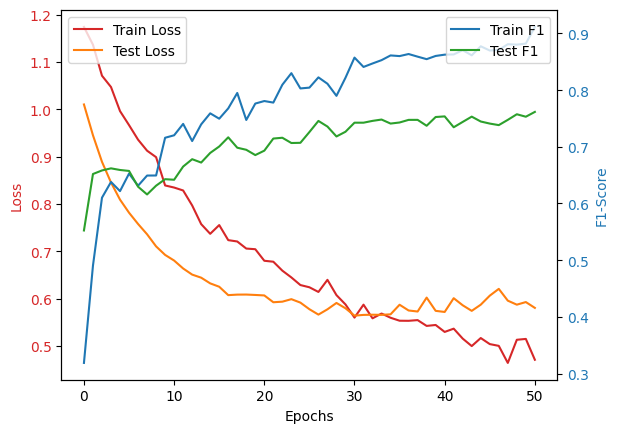

Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.44284047385056813, average F1 score 92.80149027101714
Test: Average loss 0.6420258493473132, average F1 score 76.02075551888348


In [17]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data
## Transfer adds new fc layer and new LSTM layer

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.n_epochs=200
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=20

history = train_kfold_transfer_model(dataset_12lead, trainparams, Transfer1LSTMModel, buffer=buffer, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

In [ ]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=20


for base_decay in [0.00001 * 2 ** i for i in range(10)]:
    trainparams.base_decay = base_decay

    history = train_kfold_transfer_model(dataset_12lead, trainparams, Transfer1LSTMModel, buffer=buffer, test=False, verbose=False)

    # plot_tt_graph(history, idx=0)

    print(f'\n\n\n##### decay rate {base_decay}')
    display_results(history, trainparams=trainparams)




##### decay rate 1e-05
Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.0031394222757836323, average accuracy 92.2543042259673
Test: Average loss 0.005575405785830426, average accuracy 75.34325793553714



##### decay rate 2e-05
Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.00365060051937096, average accuracy 92.10397481163325
Test: Average loss 0.0056262301620364705, average accuracy 75.40019813476168



##### decay rate 4e-05
Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.003943431980226399, average accuracy 93.4603974811633
Test: Average loss 0.005629858633990846, average accuracy 75.86563207253761



##### decay rate 8e-05
Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.00436789161980497, average accuracy 92.49444909547556
Test: Average loss 0.005634408243827259, average accuracy 74.37203658362394



##### decay rate 0.00016
Overall result

### Varying Dataset Size

In [27]:
models = [
    TransferFCModel,
    TransferAdaptersLSTMModel,
    Transfer1LSTMModel
]

km_list = [
    (10, 1),
    (10, 2),
    (10, 3),
    (10, 4),
    (10, 5),
    (10, 6),
    (10, 7),
    (10, 8),
    (7, 6),
    (10, 9),
    (15, 14),
    (20, 19),
    (30, 29),
    (40, 39),
    (50, 49)
]

test = False

hist = {}

for model in models:
    hist[model] = [{},{}]
    print(f'model {model.__name__}')

    for random_init in [True, False]:
        for k,m in km_list:
            trainparams = TrainParams()
            trainparams.weights = weights
            trainparams.labelmap = labelmap
            trainparams.n_epochs=200
            trainparams.k=k
            trainparams.m=m
            trainparams.early_stopping=5

            if random_init:
                history = train_kfold_transfer_model(dataset_12lead, trainparams, model, test=test, verbose=False)
            else:
                history = train_kfold_transfer_model(dataset_12lead, trainparams, model, buffer=buffer, test=test, verbose=False)

            hist[model][int(random_init)][(k,m)] = history

model TransferFCModel


KeyboardInterrupt: 

In [28]:
hist

{models.TransferFCModel: [{},
  {(10,
    1): {'train_loss': [[1.1023178348938625,
      1.0997001379728317,
      1.0914661884307861,
      1.05170542995135,
      0.9520475938916206,
      0.8501023401816686,
      0.7946546052893003,
      0.7099870617190996,
      0.6692216172814369,
      0.6116930569211642,
      0.5879650165637335,
      0.5577302488187948,
      0.5575165438155333,
      0.5352591859797636,
      0.5293116619189581,
      0.5116200521588326,
      0.5046320594847202,
      0.4869542034963767,
      0.4780743718147278,
      0.4843796578546365],
     [1.100977395971616,
      1.0968176672856014,
      1.0730701784292858,
      0.9985701739788055,
      0.9238091185688972,
      0.8768691544731458,
      0.813966470460097,
      0.7667599320411682,
      0.7290586133797964,
      0.6965479801098505,
      0.6815788075327873,
      0.6579585547248522,
      0.6313014775514603,
      0.6505471368630728,
      0.6183872545758883,
      0.6033452413976192,
      0.59

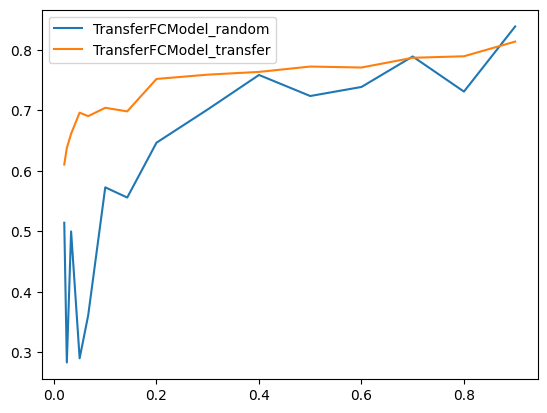

In [24]:
def display_history_varying_trainsize(hist):
    legend = []

    for model in hist.keys():
        for random_init in [True, False]:
            values = []

            for k,m in hist[model][int(random_init)].keys():
                perc_train = (k-m)/k
                
                this_hist = hist[model][int(random_init)][(k,m)]
                # print([max(x) for x in this_hist['test_F']])
                values.append((perc_train, np.mean([max(x) for x in this_hist['test_F']])))

            x,y = zip(*values)
            plt.plot(list(x), list(y))

            # plt.plot(values)
                
            if random_init:
                legend.append(f'{model.__name__}_random')
            else:
                legend.append(f'{model.__name__}_transfer')

    plt.legend(legend)

    plt.show()


display_history_varying_trainsize(hist)

## Augmented Data

In [7]:
control_dataset = WindowDataset(data_1lead, labelmap, device=device, trim_samples=1000)

8249it [00:03, 2281.80it/s]


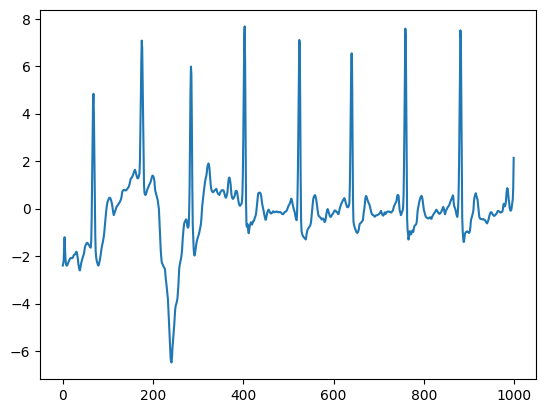

In [8]:
waveform, label, rpeaks = control_dataset.__getitem__(0, return_rpeaks=True)
plt.plot(waveform.cpu())

In [158]:
class PerlinAugment():
    def __init__(self, device, sources=2, channel_count=12):
        self.device = device

        if random.uniform(0,1) > 1.0: # I don't think doing flipx is correct at the moment.
            self.flipx = True
        else:
            self.flipx = False
        if random.uniform(0,1) > 1.0:
            self.flipy = True
        else:
            self.flipy = False

        self.perlin_values = []
        for i in range(channel_count):
            arr = []
            for j in range(sources):
                arr.append(random.uniform(-1,1))
            self.perlin_values.append(arr)

        self.channel_count = channel_count

    def __call__(self, waveform):
        shape = (len(self.perlin_values[0]),1000,100)

        g_cuda = torch.Generator(device='cuda')
        g_cuda.seed()

        perlin = FractalPerlin2D(shape, [(20,20)], [5], generator=g_cuda)()

        # perlin_noise = []
        # for i in range(len(self.perlin_values[0])):
        #     # noise = PerlinNoise(octaves=1)
        #     # perlin_noise.append([noise(i/50) for i in range(1000)])
        #     perlin_noise.append([0 for i in range(1000)])

        # perlin_noise = torch.tensor(perlin_noise, device=self.device).transpose(0,1)

        perlin_noise = perlin[:,:,50].transpose(0,1)

        # plt.plot(perlin_noise[:,0].cpu().numpy())
        # plt.plot(perlin_noise[:,1].cpu().numpy())

        output = []

        for valueset in self.perlin_values:
            thiswave = waveform.clone()

            for i,value in enumerate(valueset):
                thiswave += perlin_noise[:,i] * value

            output.append(thiswave)

        return torch.stack(output, dim=1)


class AugmentDataset(WindowDataset):
    def __init__(self, data, labelmap, threshold_length=1000, device='cpu', eval=False, trim=None, trim_samples=None):
        assert len(data[0][0].shape) == 1 ## We don't want 2d data here!
        
        super().__init__(data, labelmap, threshold_length=threshold_length, device=device, eval=eval, trim=trim, trim_samples=trim_samples)

        self.augment = PerlinAugment(device)

    def __getitem__(self, idx):
        waveform, label = super().__getitem__(idx)
        
        return self.augment(waveform), label
    
    def get_value_counts(self, count=3):
        counts = [0] * count

        for _,label in self.data:
            counts[label.item()] += 1

        return counts

In [159]:
augment_dataset = AugmentDataset(data_1lead, labelmap, device=device, trim_samples=1000)

8249it [00:04, 1812.97it/s]


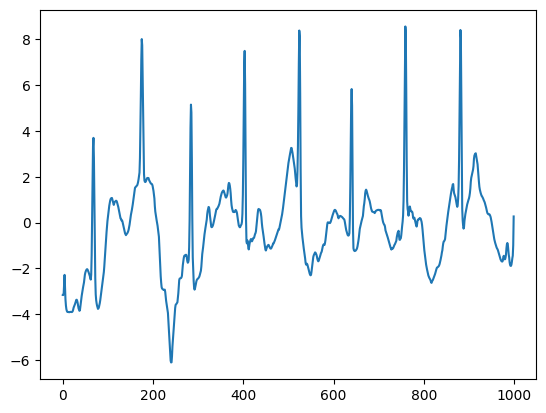

In [160]:
waveform, label = augment_dataset.__getitem__(0)
plt.plot(waveform[:,4].cpu())

In [161]:
augment_dataset.__getitem__(0)[0].shape

torch.Size([1000, 12])

In [162]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data

augment_dataset = AugmentDataset(data_1lead, labelmap, device=device, trim_samples=1000)

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=20

history = train_kfold_transfer_model(augment_dataset, trainparams, TransferFCModel, buffer=buffer, test=True)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

8249it [00:04, 2046.80it/s]


Fold 1
Epoch:10/100 AVG Training Loss:0.95272 AVG Test Loss:0.87446 AVG Training F1 26.21 % AVG Test F1 25.45 %
Epoch:20/100 AVG Training Loss:0.91118 AVG Test Loss:0.88338 AVG Training F1 58.19 % AVG Test F1 25.45 %
